In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_excel('FBA 2025 - Customer credit data.xlsx')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   customer_id                50000 non-null  object
 1   age                        50000 non-null  int64 
 2   income_level               50000 non-null  object
 3   employment_status          50000 non-null  object
 4   years_at_current_job       50000 non-null  int64 
 5   credit_score               50000 non-null  int64 
 6   existing_debt_vnd          50000 non-null  int64 
 7   savings_amount_vnd         50000 non-null  int64 
 8   home_ownership_status      50000 non-null  object
 9   loan_purpose               50000 non-null  object
 10  requested_loan_amount_vnd  50000 non-null  int64 
 11  loan_term_months           50000 non-null  int64 
 12  default_status             50000 non-null  object
dtypes: int64(7), object(6)
memory usage: 5.0+ MB


In [ ]:
df['default_status'] = df['default_status'].str.strip()
df['default_status'].head()

0       Defaulted
1    Paid in full
2    Paid in full
3       Defaulted
4    Paid in full
Name: default_status, dtype: object

# CATEGORICAL LABELING

In [ ]:
# Income Level
income_map_vietnamese = {
    'Dưới 8 triệu VND/tháng': 'Low',
    'Từ 8 - 20 triệu VND/tháng': 'Medium',
    'Từ 20 - 45 triệu VND/tháng': 'High',
    'Trên 45 triệu VND/tháng': 'Very High'
}

df['income_level_en'] = df['income_level'].map(income_map_vietnamese)

# Credit Score Rating
def assign_credit_rating(score):
    if 800 <= score <= 850:
        return 'Excellent'
    elif 740 <= score <= 799:
        return 'Very Good'
    elif 670 <= score <= 739:
        return 'Good'
    elif 580 <= score <= 669:
        return 'Fair'
    elif 300 <= score <= 579:
        return 'Poor'
    else:
        return 'Unknown'

df['credit_rating'] = df['credit_score'].apply(assign_credit_rating)

df.head()

,customer_id,age,income_level,employment_status,years_at_current_job,credit_score,existing_debt_vnd,savings_amount_vnd,home_ownership_status,loan_purpose,requested_loan_amount_vnd,loan_term_months,default_status,income_level_en,credit_rating
0,CUST-00001,65,Từ 8 - 20 triệu VND/tháng,Toàn thời gian,8,551,647700000,176700000,Thuê nhà,Hợp nhất nợ,389000000,60,Defaulted,Medium,Poor
1,CUST-00002,21,Từ 8 - 20 triệu VND/tháng,Toàn thời gian,0,754,263900000,585700000,Thuê nhà,Sửa chữa nhà,644000000,36,Paid in full,Medium,Very Good
2,CUST-00003,59,Từ 8 - 20 triệu VND/tháng,Toàn thời gian,22,654,650700000,323900000,Thuê nhà,Hợp nhất nợ,284000000,36,Paid in full,Medium,Fair
3,CUST-00004,36,Từ 8 - 20 triệu VND/tháng,Bán thời gian,8,488,230900000,142000000,Thuê nhà,Sửa chữa nhà,392000000,36,Defaulted,Medium,Poor
4,CUST-00005,52,Từ 8 - 20 triệu VND/tháng,Toàn thời gian,30,728,163000000,86200000,Trả góp,Hợp nhất nợ,400000000,24,Paid in full,Medium,Good


# VARIABLE ADDING

In [ ]:
df['is_default'] = df['default_status'].replace({'Defaulted': 1, 'Paid in full': 0})

C:\Users\KIEU VI\AppData\Local\Temp\ipykernel_7180\1031705083.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_default'] = df['default_status'].replace({'Defaulted': 1, 'Paid in full': 0})


In [ ]:
df_ratios = df.copy()

# Create an estimated income column based on the coded income_level_en (0=Low, 1=Medium, ...)
# These numbers are estimates, but will help create meaningful ratios
income_mapping_vnd = {
    'Low': 6000000,
    'Medium': 14000000,
    'High': 32500000,
    'Very High': 60000000
}
df_ratios['estimated_income_vnd'] = df_ratios['income_level_en'].map(income_mapping_vnd)

# 1. Debt-to-Income Ratio (DTI)
df_ratios['dti_ratio'] = df_ratios['existing_debt_vnd'] / (df_ratios['estimated_income_vnd'])

# 2. Loan-to-Income Ratio (LTI)
df_ratios['lti_ratio'] = df_ratios['requested_loan_amount_vnd'] / (df_ratios['estimated_income_vnd'])

# 3. Debt-to-Savings Ratio
df_ratios['debt_to_savings_ratio'] = df_ratios['existing_debt_vnd'] / (df_ratios['savings_amount_vnd'])

print(df_ratios[['dti_ratio', 'lti_ratio', 'debt_to_savings_ratio']].head())

   dti_ratio  lti_ratio  debt_to_savings_ratio
0    46.2643    27.7857                 3.6655
1    18.8500    46.0000                 0.4506
2    46.4786    20.2857                 2.0090
3    16.4929    28.0000                 1.6261
4    11.6429    28.5714                 1.8910


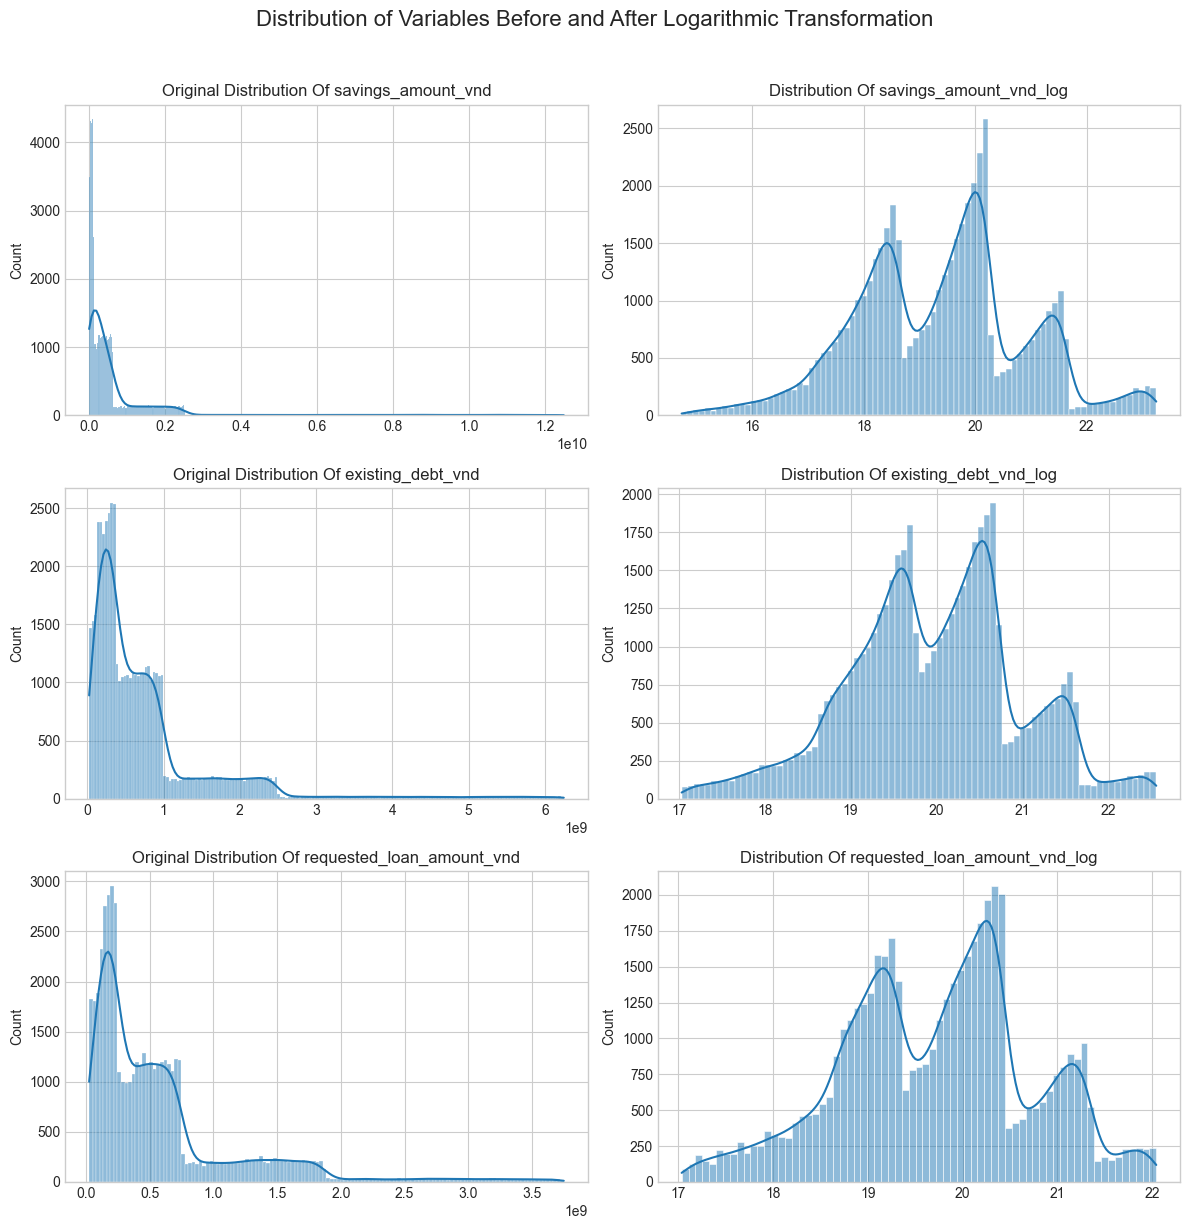

In [ ]:
df_transformed = df_ratios.copy()

financial_cols = [
    'savings_amount_vnd',
    'existing_debt_vnd',
    'requested_loan_amount_vnd'
]

# We will create new columns with the suffix '_log' to retain the original columns
for col in financial_cols:
    df_transformed[col + '_log'] = np.log1p(df_transformed[col])

fig, axes = plt.subplots(len(financial_cols), 2, figsize=(12, len(financial_cols) * 4))
fig.suptitle('Distribution of Variables Before and After Logarithmic Transformation', fontsize=16, y=1.02)

for i, col in enumerate(financial_cols):
    sns.histplot(df_transformed[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Original Distribution Of {col}')
    axes[i, 0].set_xlabel('')

    sns.histplot(df_transformed[col + '_log'], kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'Distribution Of {col}_log')
    axes[i, 1].set_xlabel('')

plt.tight_layout()
plt.show()

In [ ]:
df_transformed = df_transformed.drop(['estimated_income_vnd',"savings_amount_vnd", "existing_debt_vnd",'requested_loan_amount_vnd'], axis=1)

In [ ]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    50000 non-null  object 
 1   age                            50000 non-null  int64  
 2   income_level                   50000 non-null  object 
 3   employment_status              50000 non-null  object 
 4   years_at_current_job           50000 non-null  int64  
 5   credit_score                   50000 non-null  int64  
 6   home_ownership_status          50000 non-null  object 
 7   loan_purpose                   50000 non-null  object 
 8   loan_term_months               50000 non-null  int64  
 9   default_status                 50000 non-null  object 
 10  income_level_en                50000 non-null  object 
 11  credit_rating                  50000 non-null  object 
 12  is_default                     50000 non-null 

# ENCODING

In [ ]:
df_encoded = df_transformed.copy()

# Encode Ordinal variables using .map()

# income_level_en
income_map = {
    'Low': 0,
    'Medium': 1,
    'High': 2,
    'Very High': 3
}
df_encoded['income_level_en'] = df_encoded['income_level_en'].map(income_map)

# credit_rating
credit_map = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2,
    'Very Good': 3,
    'Excellent': 4
}
df_encoded['credit_rating'] = df_encoded['credit_rating'].map(credit_map)


# Encode Nominal (unordered) variables using pd.get_dummies() ---
nominal_cols = [
    'employment_status',
    'home_ownership_status',
    'loan_purpose']

df_encoded = pd.get_dummies(df_encoded, columns=nominal_cols, drop_first=True, dtype=int)

columns_to_drop = ['customer_id', 'default_status', 'income_level']
df_encoded = df_encoded.drop(columns=columns_to_drop, errors='ignore')

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   age                               50000 non-null  int64  
 1   years_at_current_job              50000 non-null  int64  
 2   credit_score                      50000 non-null  int64  
 3   loan_term_months                  50000 non-null  int64  
 4   income_level_en                   50000 non-null  int64  
 5   credit_rating                     50000 non-null  int64  
 6   is_default                        50000 non-null  int64  
 7   dti_ratio                         50000 non-null  float64
 8   lti_ratio                         50000 non-null  float64
 9   debt_to_savings_ratio             50000 non-null  float64
 10  savings_amount_vnd_log            50000 non-null  float64
 11  existing_debt_vnd_log             50000 non-null  float64
 12  requ

# HEATMAP

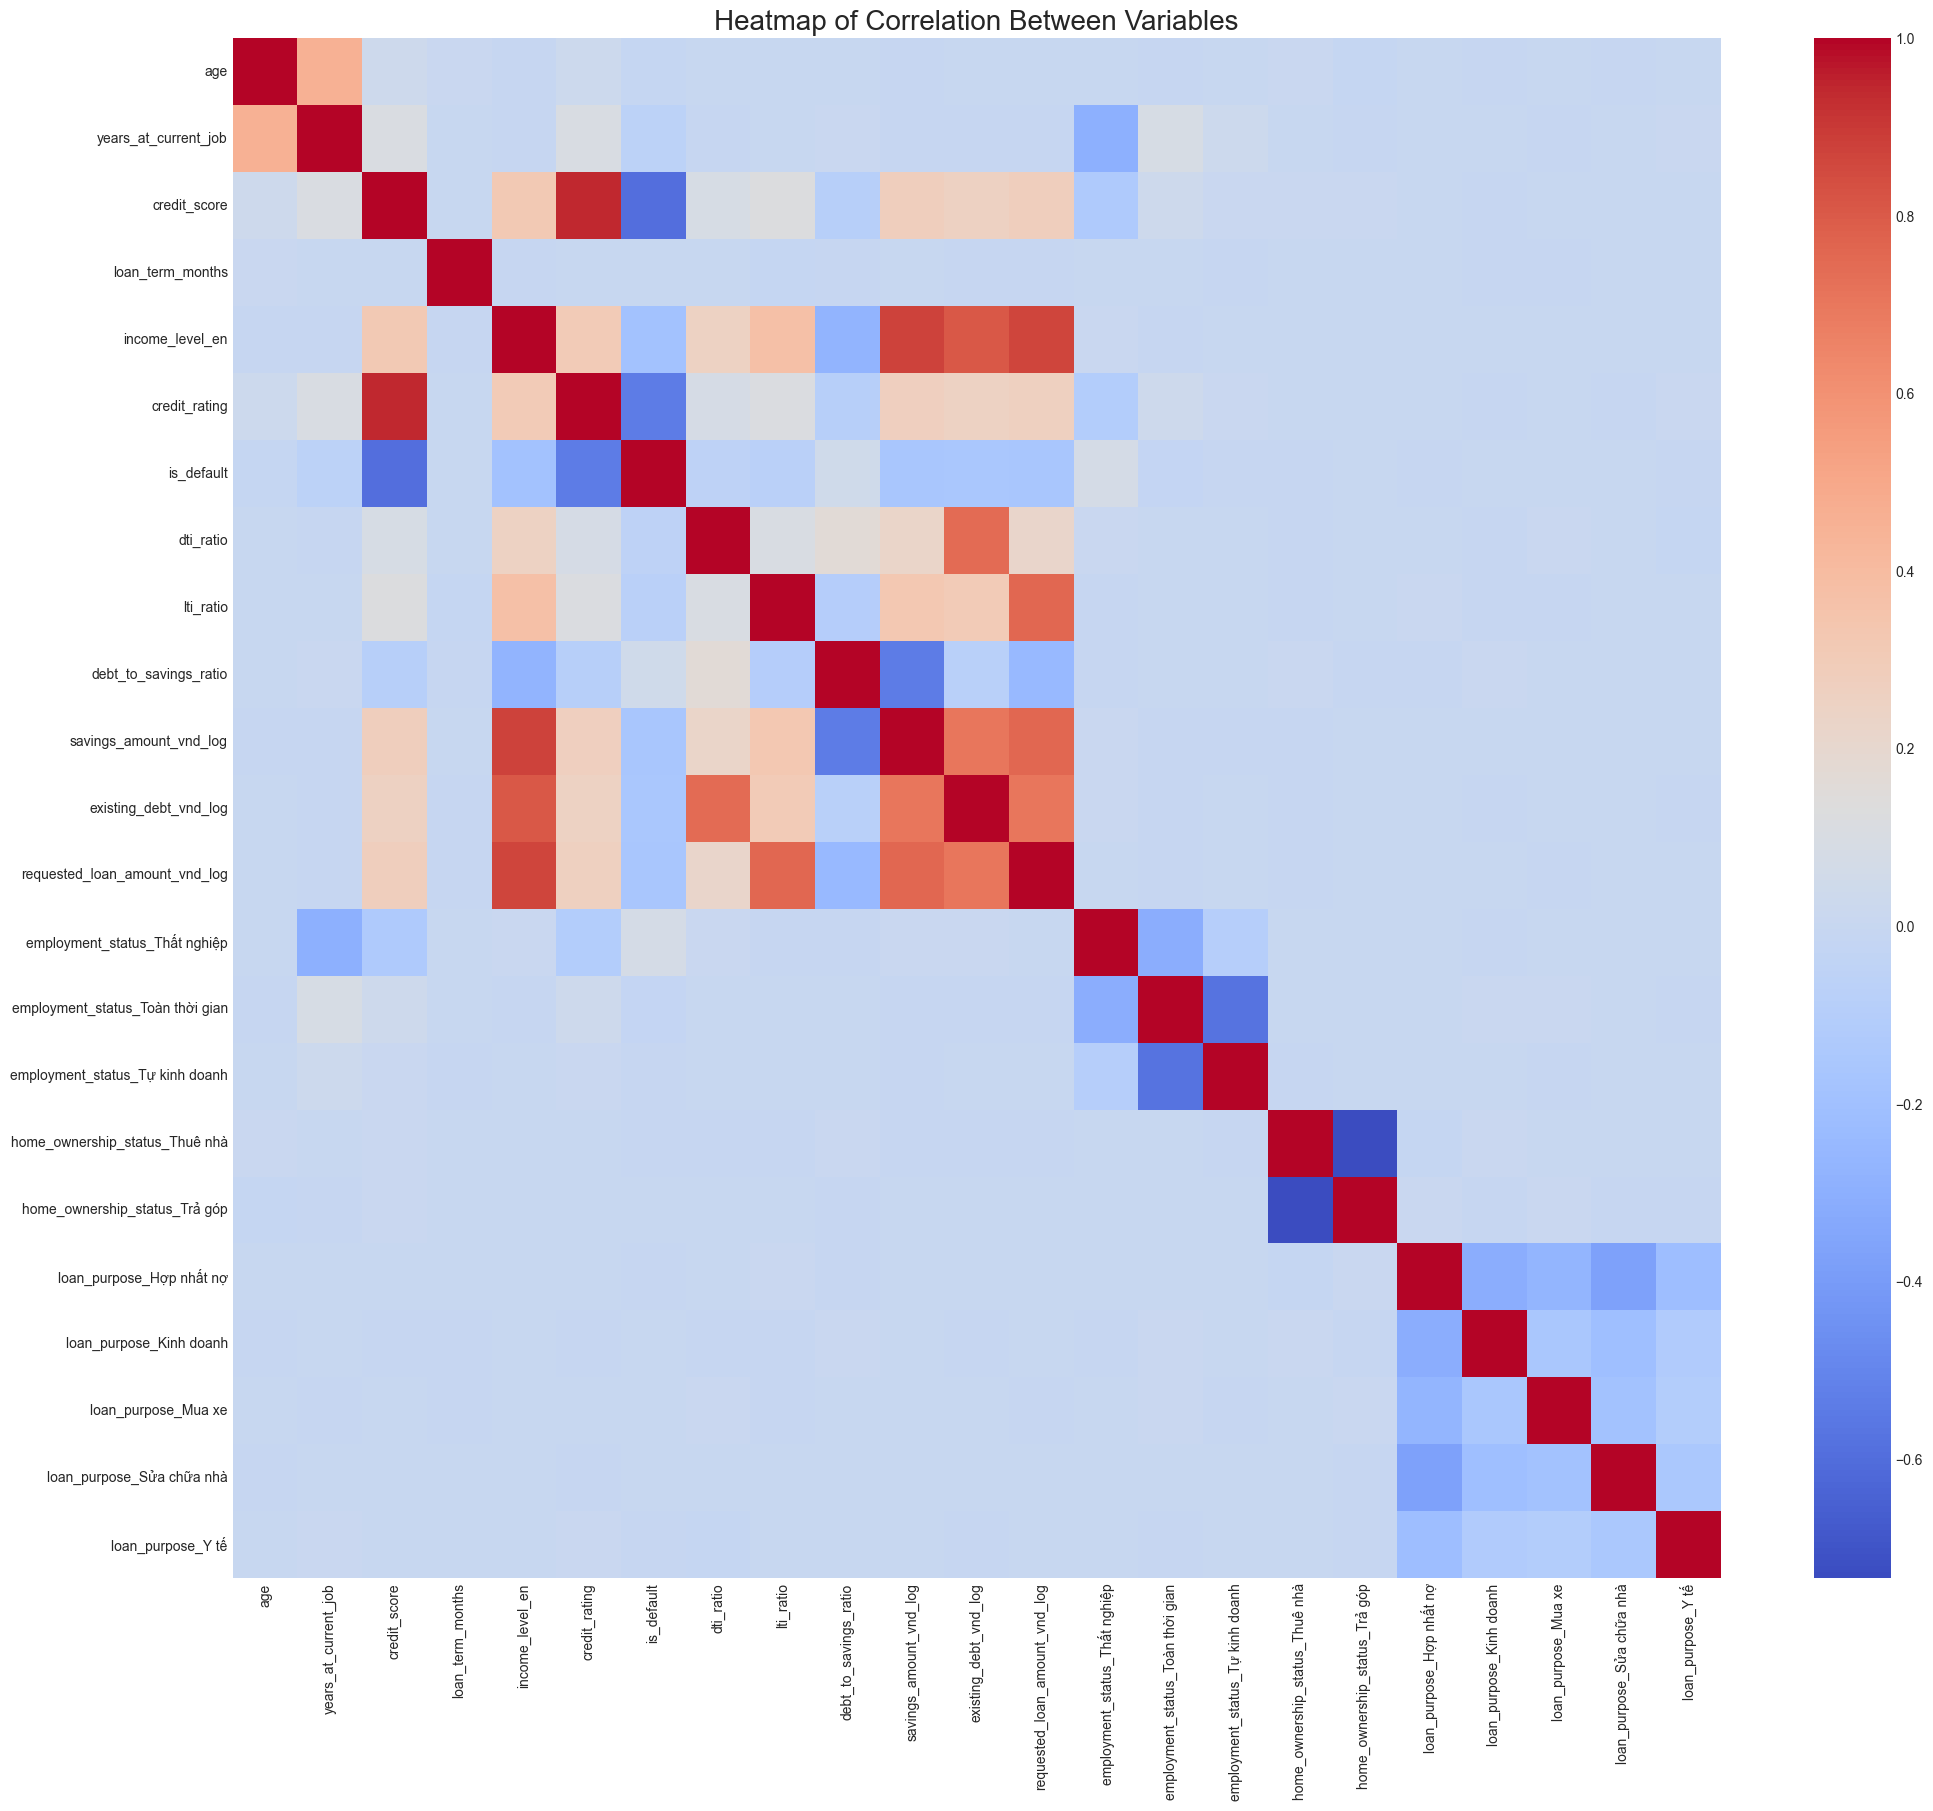

In [ ]:
corr_matrix = df_encoded.corr()

plt.figure(figsize=(24, 20))

sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)

plt.title('Heatmap of Correlation Between Variables', fontsize=20)

plt.show()

C:\Users\KIEU VI\AppData\Local\Temp\ipykernel_7180\312938757.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='vlag')


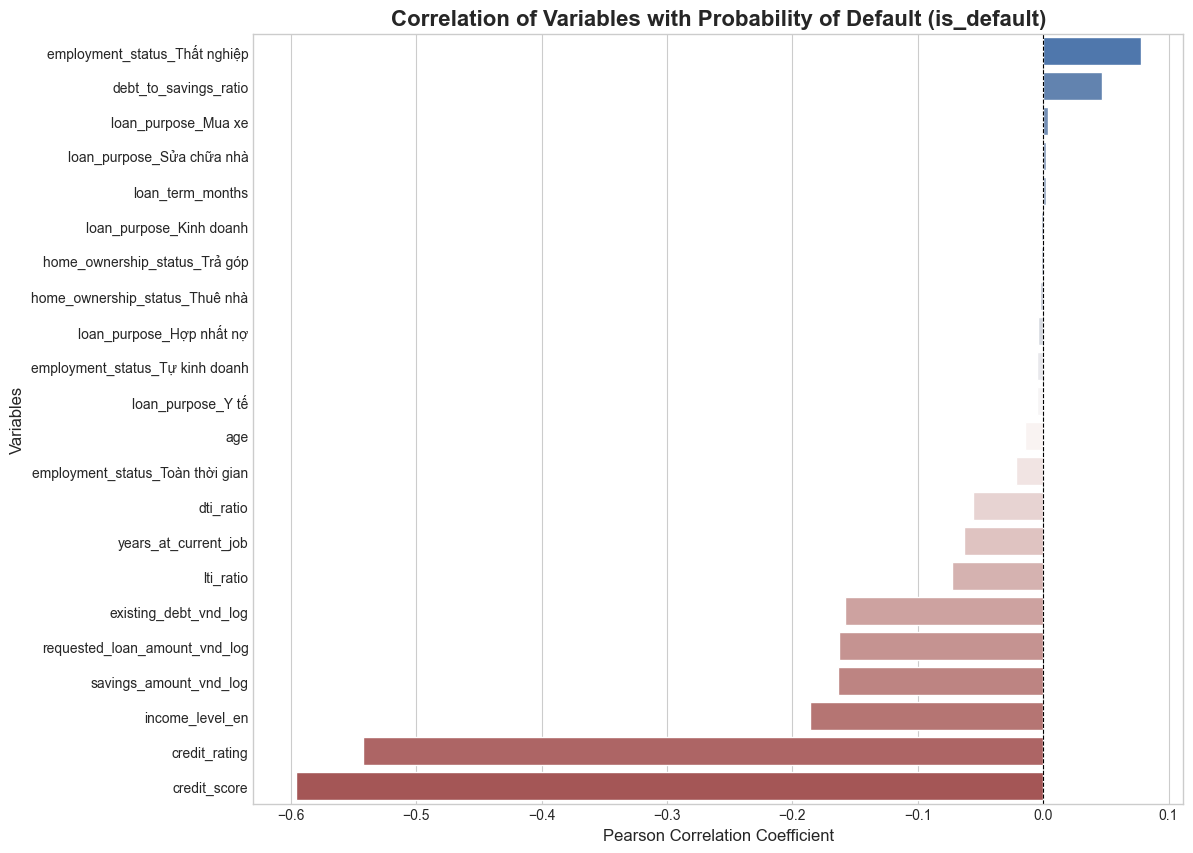

In [ ]:
corr_with_target = corr_matrix['is_default'].drop('is_default').sort_values(ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='vlag')
plt.title('Correlation of Variables with Probability of Default (is_default)', fontsize=16, fontweight='bold')
plt.xlabel('Pearson Correlation Coefficient', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.axvline(x=0, color='black', linewidth=0.8, linestyle='--')

plt.show()

# MODEL PICKING

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

sns.set_style('whitegrid')


In [ ]:
TARGET = 'is_default'
FEATURES_TO_DROP = ['interest_rate', 'credit_rating','credit_score' ]
COLUMNS_TO_EXCLUDE = [TARGET] + FEATURES_TO_DROP
features = [col for col in df_encoded.columns if col not in COLUMNS_TO_EXCLUDE]

X = df_encoded[features]
y = df_encoded[TARGET]

print(f"Use {len(features)} variable to predict.")
print(f"X-Dimensions: {X.shape}")
print(f"y-Dimensions: {y.shape}")


Use 20 variable to predict.
X-Dimensions: (50000, 20)
y-Dimensions: (50000,)


In [ ]:
# Divide 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nDefault rate in the training set:{y_train.mean():.2%}")
print(f"Default rate in the test set: {y_test.mean():.2%}")



Default rate in the training set:31.01%
Default rate in the test set: 31.01%


In [ ]:
# Calculate scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"\nScale Pos Weight: {scale_pos_weight:.2f}")


Scale Pos Weight: 2.22


In [ ]:
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    ),
    'Random Forest': RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'XGBoost': xgb.XGBClassifier(
        random_state=42,
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight
    ),
    'LightGBM': lgb.LGBMClassifier(
        random_state=42,
        objective='binary',
        metric='auc',
        scale_pos_weight=scale_pos_weight
    )
}

results = {}

for name, model in models.items():

    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    auc_score = roc_auc_score(y_test, y_pred_proba)

    results[name] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': auc_score
    }
    print(f"AUC Score of {name}: {auc_score:.4f}\n")


AUC Score of Logistic Regression: 0.6308

AUC Score of Random Forest: 0.5960



c:\Users\KIEU VI\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:29:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC Score of XGBoost: 0.5967

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 12404, number of negative: 27596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1637
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.310100 -> initscore=-0.799652
[LightGBM] [Info] Start training from score -0.799652
AUC Score of LightGBM: 0.6211



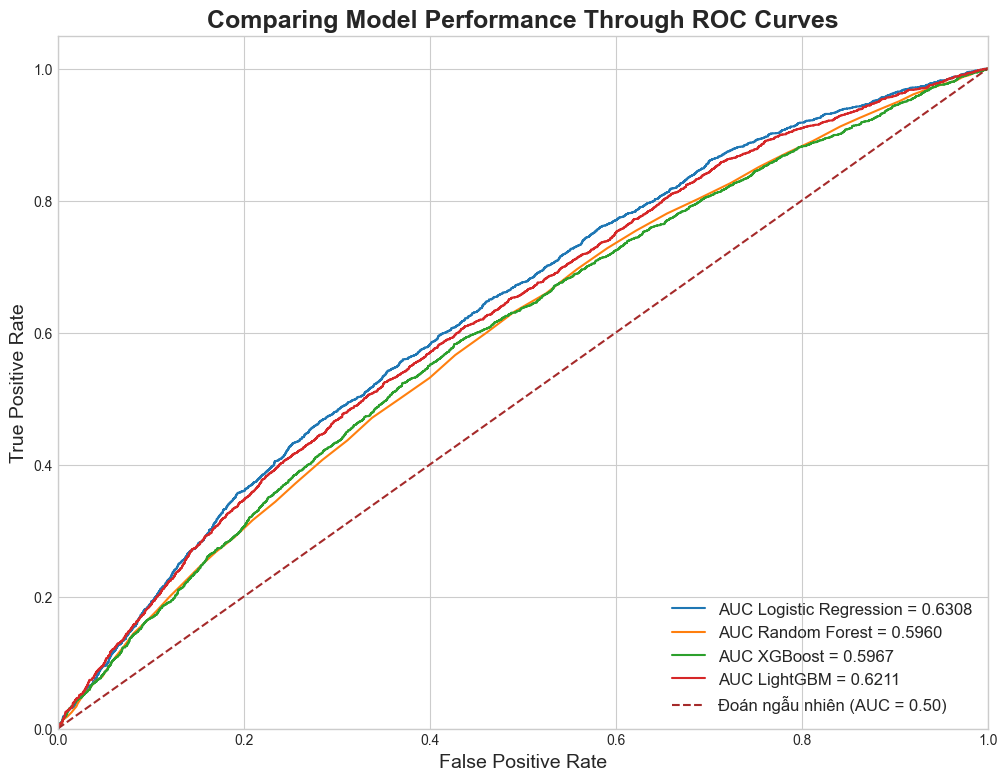

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 9))

for name, data in results.items():
    plt.plot(data['fpr'], data['tpr'], label=f"AUC {name} = {data['auc']:.4f}")

plt.plot([0, 1], [0, 1], color='brown', linestyle='--', label='Đoán ngẫu nhiên (AUC = 0.50)')

# Tùy chỉnh biểu đồ
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Comparing Model Performance Through ROC Curves', fontsize=18, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

## Logistic Regression

In [ ]:
logistic_model = LogisticRegression(
    random_state=42,
    class_weight='balanced',
    max_iter=1000
)

logistic_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Accuracy: 0.5998
ROC AUC Score: 0.6308


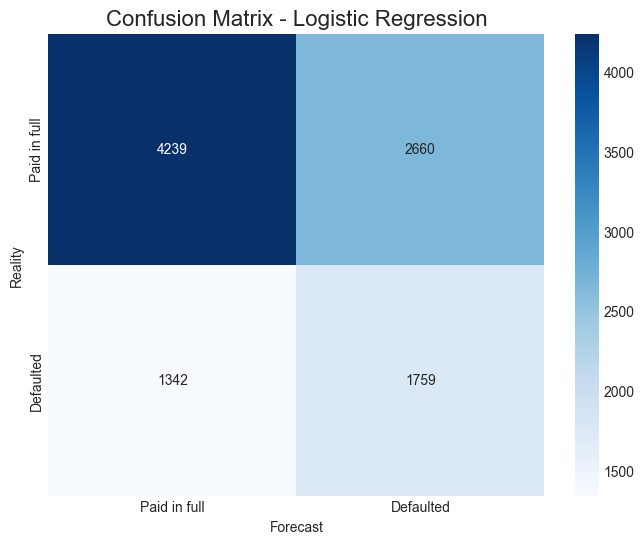


Classification Report:
                   precision    recall  f1-score   support

Thanh toán đủ (0)       0.76      0.61      0.68      6899
        Vỡ nợ (1)       0.40      0.57      0.47      3101

         accuracy                           0.60     10000
        macro avg       0.58      0.59      0.57     10000
     weighted avg       0.65      0.60      0.61     10000



In [ ]:
y_pred = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {auc_score:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Paid in full', 'Defaulted'], yticklabels=['Paid in full', 'Defaulted'])
plt.title('Confusion Matrix - Logistic Regression', fontsize=16)
plt.ylabel('Reality')
plt.xlabel('Forecast')
plt.show()

# In Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Thanh toán đủ (0)', 'Vỡ nợ (1)']))

In [ ]:
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logistic_model.coef_[0]
})
coefficients['Odds_Ratio'] = np.exp(coefficients['Coefficient'])
coefficients = coefficients.sort_values(by='Odds_Ratio', ascending=False)

pd.set_option('display.float_format', lambda x: '%.4f' % x)
print(coefficients)

                             Feature  Coefficient  Odds_Ratio
10     employment_status_Thất nghiệp       0.6482      1.9121
9      requested_loan_amount_vnd_log       0.1293      1.1381
12   employment_status_Tự kinh doanh       0.0255      1.0258
11  employment_status_Toàn thời gian       0.0015      1.0015
4                          dti_ratio       0.0013      1.0013
2                   loan_term_months       0.0008      1.0008
0                                age       0.0004      1.0004
6              debt_to_savings_ratio      -0.0011      0.9989
5                          lti_ratio      -0.0059      0.9941
7             savings_amount_vnd_log      -0.0084      0.9916
1               years_at_current_job      -0.0126      0.9874
18         loan_purpose_Sửa chữa nhà      -0.0163      0.9838
16           loan_purpose_Kinh doanh      -0.0290      0.9714
17               loan_purpose_Mua xe      -0.0390      0.9617
15          loan_purpose_Hợp nhất nợ      -0.0416      0.9592
13    ho

## LightGBM

In [ ]:
lgbm = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    random_state=42,
    n_jobs=-1,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1
    ,scale_pos_weight=scale_pos_weight
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(100, verbose=False)] # Stop early if performance does not improve after 100 laps
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 12404, number of negative: 27596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1637
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.310100 -> initscore=-0.799652
[LightGBM] [Info] Start training from score -0.799652


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [ ]:
y_pred = lgbm.predict(X_test)
y_pred_proba = lgbm.predict_proba(X_test)[:, 1]

Accuracy: 0.6395
ROC AUC Score: 0.6293


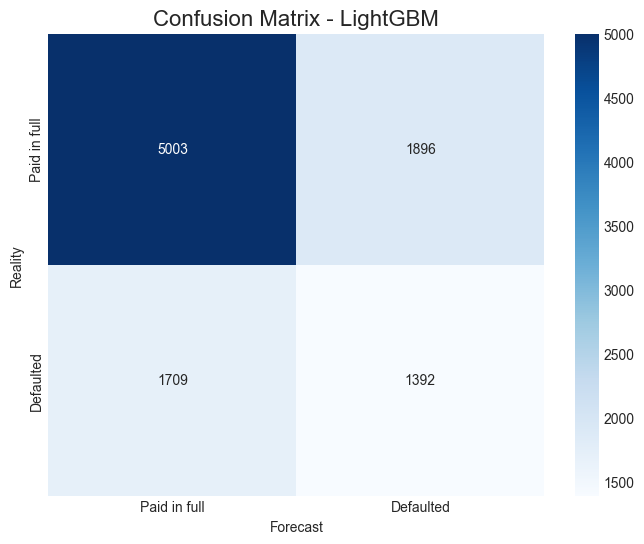


Classification Report:
                  precision    recall  f1-score   support

Paid in full (0)       0.75      0.73      0.74      6899
   Defaulted (1)       0.42      0.45      0.44      3101

        accuracy                           0.64     10000
       macro avg       0.58      0.59      0.59     10000
    weighted avg       0.65      0.64      0.64     10000



In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {auc_score:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Paid in full', 'Defaulted'],
            yticklabels=['Paid in full', 'Defaulted'])
plt.title('Confusion Matrix - LightGBM', fontsize=16)
plt.ylabel('Reality')
plt.xlabel('Forecast')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Paid in full (0)', 'Defaulted (1)']))


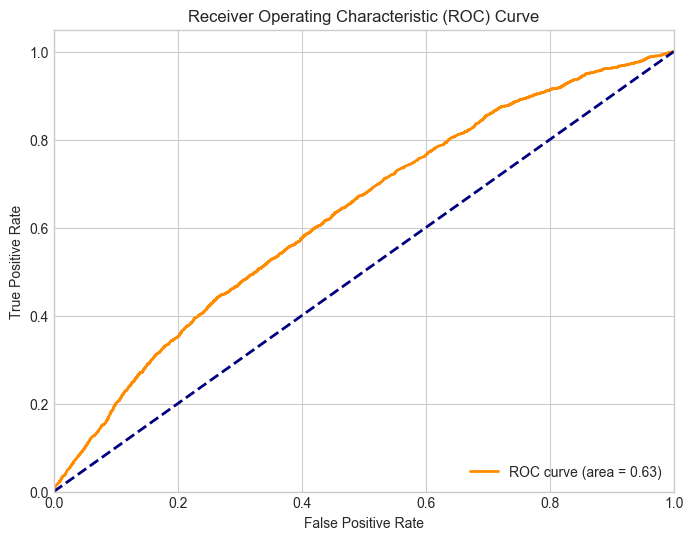

<Figure size 1000x1200 with 0 Axes>

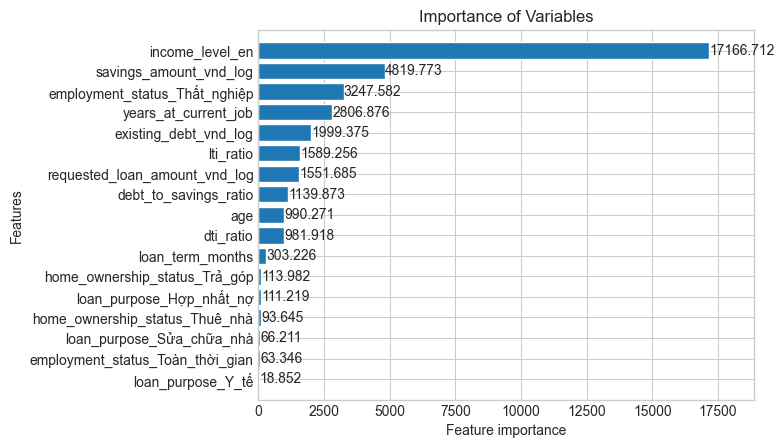

In [ ]:
# 1. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Feature Importance
plt.figure(figsize=(10, 12))
lgb.plot_importance(lgbm, max_num_features=20, height=0.8,
                    title='Importance of Variables',
                    importance_type='gain')
plt.show()

# RULE FIT MODEL

In [ ]:
from rulefit import RuleFit

SAMPLE_SIZE = 15000

rf_model_final = RuleFit(
    max_rules=500,
    tree_size=4,
    rfmode='predict',
    random_state=42
)

rf_model_final.fit(
    X_train.values,
    y_train,
    feature_names=X_train.columns
)

,tree_size,4
,sample_fract,'default'
,max_rules,500
,memory_par,0.01
,tree_generator,GradientBoost...oat64(0.0325))
,rfmode,'predict'
,lin_trim_quantile,0.025
,lin_standardise,True
,exp_rand_tree_size,True
,model_type,'rl'
,Cs,None


In [ ]:
y_pred_proba_rf = rf_model_final.predict(X_test.values)

# AUC
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"\nAUC score of RuleFit model: {auc_rf:.4f}")

rules = rf_model_final.get_rules()
rules = rules[rules['coef'] != 0].sort_values(by='importance', ascending=False)

pd.set_option('display.max_colwidth', None)
rules.head(20)


AUC score of RuleFit model: 0.5079


,rule,type,coef,support,importance
3,income_level_en,linear,-0.2578,1.0000,0.2158
191,years_at_current_job > 10.5,rule,-0.1645,0.4569,0.0820
474,existing_debt_vnd_log <= 21.49045181274414 & years_at_current_job <= 7.5 & existing_debt_vnd_log <= 21.52268123626709 & years_at_current_job <= 8.5 & employment_status_Thất nghiệp > 0.5,rule,0.3020,0.0462,0.0634
236,employment_status_Thất nghiệp <= 0.5 & requested_loan_amount_vnd_log > 19.25141143798828,rule,-0.1100,0.6223,0.0533
186,employment_status_Thất nghiệp <= 0.5 & requested_loan_amount_vnd_log > 20.70152473449707 & income_level_en > 0.5 & lti_ratio > 25.258333206176758,rule,-0.1157,0.1523,0.0416
441,employment_status_Thất nghiệp <= 0.5 & requested_loan_amount_vnd_log > 18.647808074951172,rule,-0.1112,0.8354,0.0412
62,years_at_current_job <= 5.5 & existing_debt_vnd_log <= 19.725357055664062,rule,0.1095,0.1400,0.0380
280,requested_loan_amount_vnd_log > 19.162516593933105 & existing_debt_vnd_log > 20.45786476135254,rule,-0.0765,0.3131,0.0355
260,employment_status_Thất nghiệp <= 0.5 & existing_debt_vnd_log > 19.667713165283203,rule,-0.0617,0.5700,0.0306
193,requested_loan_amount_vnd_log <= 19.854573249816895 & lti_ratio > 25.964285850524902,rule,0.0795,0.1646,0.0295


# SEGMENT

In [ ]:
from sklearn.preprocessing import StandardScaler

features_for_clustering = [
    'income_level_en',
    'savings_amount_vnd_log',
    'employment_status_Thất nghiệp',
    'existing_debt_vnd_log',
    'lti_ratio',
    'requested_loan_amount_vnd_log',
    'debt_to_savings_ratio',
    'dti_ratio'
]

df_cluster = df_encoded[features_for_clustering].copy()

# StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

X_scaled.shape

(50000, 8)

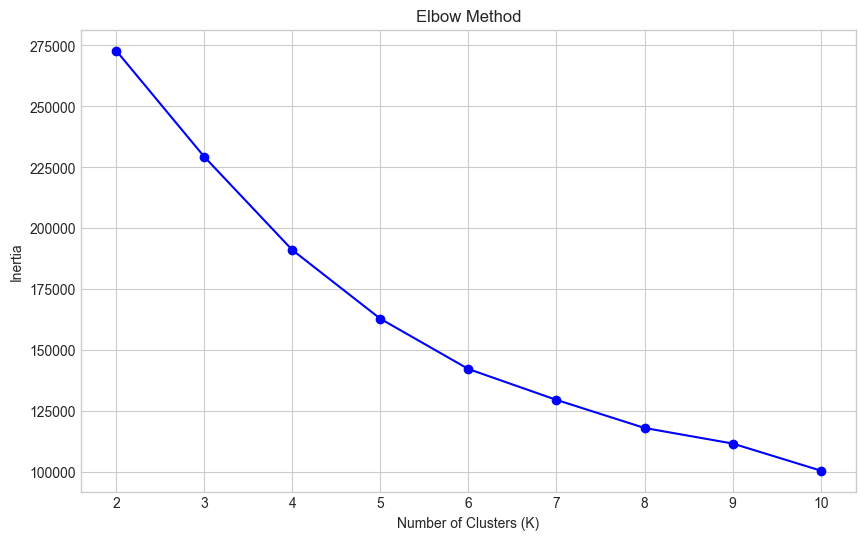

In [ ]:
from sklearn.cluster import KMeans

inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [ ]:
OPTIMAL_K = 4

kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init='auto')
df_cluster['segment'] = kmeans.fit_predict(X_scaled)

print(df_cluster['segment'].value_counts())

segment_profiles = df_cluster.groupby('segment').mean()
segment_profiles['size'] = df_cluster['segment'].value_counts()

segment_profiles.T

segment
1    22001
2    15133
3    10419
0     2447
Name: count, dtype: int64


segment,0,1,2,3
income_level_en,1.0257,1.0610,0.0821,2.2271
savings_amount_vnd_log,19.3874,19.5271,17.7742,21.3010
employment_status_Thất nghiệp,1.0000,0.0000,0.0000,0.0002
existing_debt_vnd_log,19.9934,20.0618,18.9666,21.2115
lti_ratio,29.7406,31.6171,21.9545,37.8926
requested_loan_amount_vnd_log,19.7278,19.8659,18.6228,21.0035
debt_to_savings_ratio,3.4541,2.6889,6.4083,1.3125
dti_ratio,39.9383,39.9609,32.1432,49.0415
size,2447.0000,22001.0000,15133.0000,10419.0000


## Visulize

In [ ]:
from sklearn.preprocessing import MinMaxScaler

segment_profiles_for_scaling = segment_profiles.drop('size', axis=1)

# Use MinMaxScaler to output all values ​​in the range 0-1
scaler = MinMaxScaler()
profiles_scaled = pd.DataFrame(scaler.fit_transform(segment_profiles_for_scaling),
                               columns=segment_profiles_for_scaling.columns,
                               index=segment_profiles_for_scaling.index)

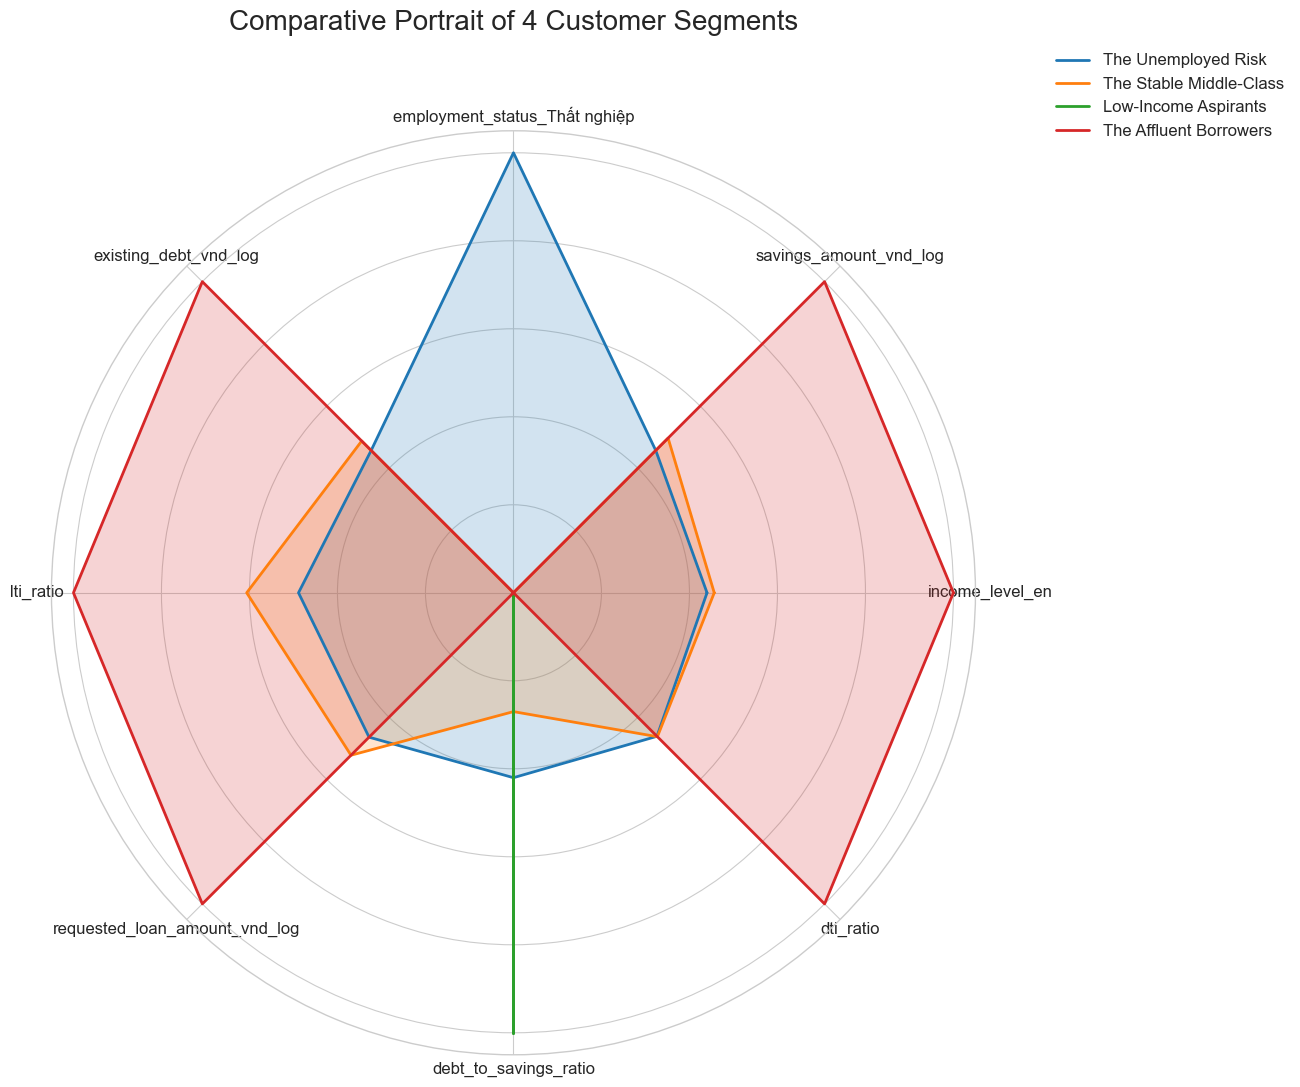

In [ ]:
# SPIDER PLOT
labels = profiles_scaled.columns
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

segment_names = {
    0: 'The Unemployed Risk',
    1: 'The Stable Middle-Class',
    2: 'Low-Income Aspirants',
    3: 'The Affluent Borrowers'
}

for i, row in profiles_scaled.iterrows():
    values = row.values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=segment_names.get(i, f'Segment {i}'))
    ax.fill(angles, values, alpha=0.2)

ax.set_yticklabels([])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, size=12)

plt.title('Comparative Portrait of 4 Customer Segments', size=20, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1), fontsize=12)

plt.show()

--- Tỷ Lệ Vỡ Nợ Thực Tế Của Từng Phân Khúc ---
         default_rate_percent   size
segment                             
0                     46.9600   2447
1                     29.0000  22001
2                     40.4700  15133
3                     17.7600  10419


C:\Users\KIEU VI\AppData\Local\Temp\ipykernel_7180\2950113524.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


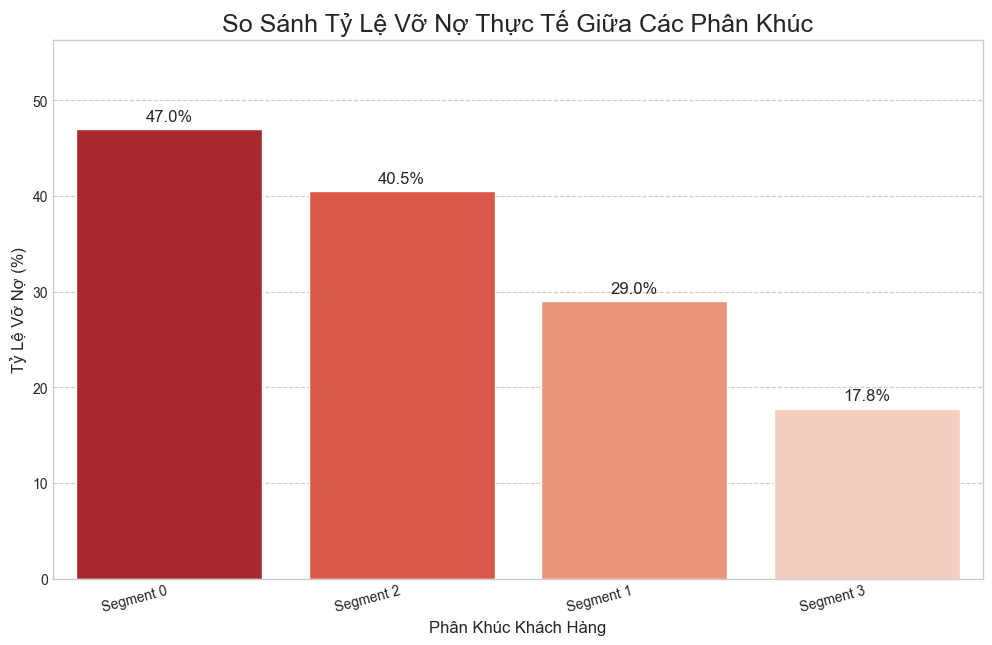

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Giả sử bạn đã có:
# 1. df: DataFrame gốc chứa cột 'is_default' (biến mục tiêu).
# 2. df_cluster: DataFrame từ bước K-Means chứa cột 'segment'.

# === BƯỚC 1: KẾT HỢP THÔNG TIN PHÂN KHÚC VÀ KẾT QUẢ VỠ NỢ ===
# Đảm bảo cả hai DataFrame có cùng index để có thể kết hợp
# Gán cột 'segment' từ df_cluster vào DataFrame gốc
df_with_segments = df.copy()
df_with_segments['segment'] = df_cluster['segment']


# === BƯỚC 2: TÍNH TOÁN TỶ LỆ VỠ NỢ CHO TỪNG PHÂN KHÚC ===
# Group by 'segment' và tính trung bình của 'is_default'
# Vì 'is_default' có giá trị 0 và 1, giá trị trung bình chính là tỷ lệ của các giá trị 1 (vỡ nợ)
default_rates = df_with_segments.groupby('segment')['is_default'].mean() * 100

# Chuyển thành DataFrame để dễ xử lý và thêm cột kích thước
default_rates_df = pd.DataFrame(default_rates).rename(columns={'is_default': 'default_rate_percent'})
default_rates_df['size'] = df_cluster['segment'].value_counts()

print("--- Tỷ Lệ Vỡ Nợ Thực Tế Của Từng Phân Khúc ---")
print(default_rates_df.round(2))


# === BƯỚC 3: TRỰC QUAN HÓA KẾT QUẢ ===
# Reset index để có thể dùng 'segment' làm trục x
default_rates_to_plot = default_rates_df.reset_index()

# Gán lại tên cho các segment để biểu đồ dễ đọc hơn
segment_names = {
    0: 'Segment 0',
    1: 'Segment 1',
    2: 'Segment 2',
    3: 'Segment 3'
}
default_rates_to_plot['segment_name'] = default_rates_to_plot['segment'].map(segment_names)


plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=default_rates_to_plot.sort_values('default_rate_percent', ascending=False),
    x='segment_name',
    y='default_rate_percent',
    palette='Reds_r' # Bảng màu đỏ, màu càng đậm rủi ro càng cao
)

# Thêm nhãn số liệu trên mỗi cột
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=12)


# Tùy chỉnh biểu đồ
plt.title('So Sánh Tỷ Lệ Vỡ Nợ Thực Tế Giữa Các Phân Khúc', fontsize=18)
plt.xlabel('Phân Khúc Khách Hàng', fontsize=12)
plt.ylabel('Tỷ Lệ Vỡ Nợ (%)', fontsize=12)
plt.xticks(rotation=15, ha='right')
plt.ylim(0, default_rates_df['default_rate_percent'].max() * 1.2) # Tự động điều chỉnh trục y
plt.grid(axis='y', linestyle='--')
plt.show()

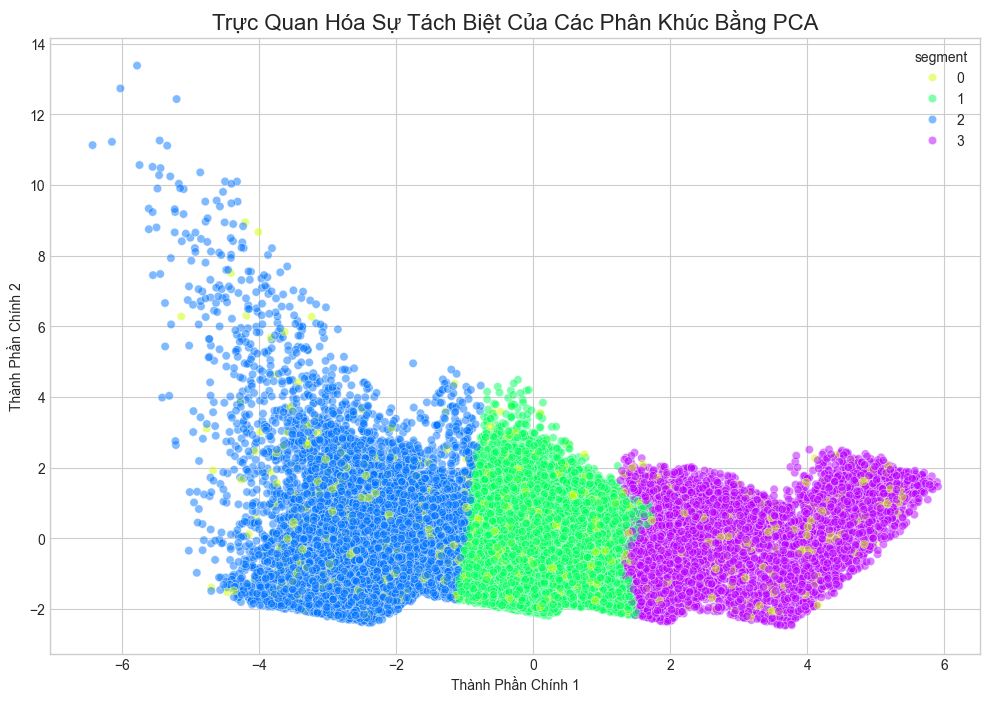

In [ ]:
from sklearn.decomposition import PCA

# Sử dụng PCA để giảm 11 chiều dữ liệu xuống còn 2 chiều để vẽ
pca = PCA(n_components=2)
# X_scaled là dữ liệu đã chuẩn hóa của TẤT CẢ khách hàng
principal_components = pca.fit_transform(X_scaled)

# Tạo DataFrame cho PCA
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
# Gán nhãn segment đã tìm được
pca_df['segment'] = df_cluster['segment']

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="segment",
    palette=sns.color_palette("hsv", 4),
    data=pca_df,
    legend="full",
    alpha=0.5
)
plt.title('Trực Quan Hóa Sự Tách Biệt Của Các Phân Khúc Bằng PCA', fontsize=16)
plt.xlabel('Thành Phần Chính 1')
plt.ylabel('Thành Phần Chính 2')
plt.show()

# Other

--- Phân Bổ Mức Thu Nhập Theo Tình Trạng Việc Làm (Số Lượng) ---
income_level_en    High   Low  Medium  Very High
employment_status                               
Bán thời gian      1595  2187    3387        358
Thất nghiệp         532   723    1065        129
Toàn thời gian     6532  9704   14521       1624
Tự kinh doanh      1550  2300    3402        391

--- Phân Bổ Mức Thu Nhập Theo Tình Trạng Việc Làm (Tỷ Lệ %) ---
income_level_en      High     Low  Medium  Very High
employment_status                                   
Bán thời gian     21.1900 29.0600 45.0000     4.7600
Thất nghiệp       21.7200 29.5200 43.4900     5.2700
Toàn thời gian    20.1700 29.9700 44.8400     5.0200
Tự kinh doanh     20.2800 30.0900 44.5100     5.1200


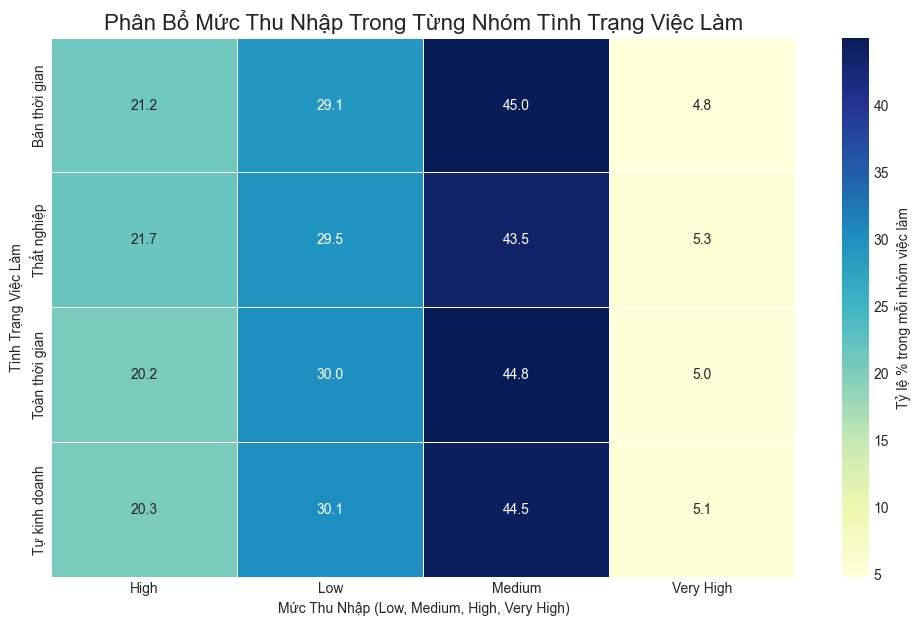

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Giả sử df là DataFrame gốc của bạn, chứa các cột gốc chưa qua xử lý
# df = pd.read_csv('your_data.csv')

# === BƯỚC 1: TẠO BẢNG CHÉO ===
# Tạo bảng đếm số lượng khách hàng cho mỗi cặp (Tình trạng việc làm, Mức thu nhập)
cross_tab = pd.crosstab(
    df['employment_status'],
    df['income_level_en']
)

print("--- Phân Bổ Mức Thu Nhập Theo Tình Trạng Việc Làm (Số Lượng) ---")
print(cross_tab)


# === BƯỚC 2: CHUYỂN SANG TỶ LỆ PHẦN TRĂM ĐỂ DỄ SO SÁNH ===
# normalize='index' sẽ tính tỷ lệ phần trăm theo từng hàng (từng tình trạng việc làm)
cross_tab_percent = pd.crosstab(
    df['employment_status'],
    df['income_level_en'],
    normalize='index'
) * 100

print("\n--- Phân Bổ Mức Thu Nhập Theo Tình Trạng Việc Làm (Tỷ Lệ %) ---")
print(cross_tab_percent.round(2)) # Làm tròn đến 2 chữ số thập phân


# === BƯỚC 3: TRỰC QUAN HÓA BẢNG TỶ LỆ BẰNG HEATMAP ===
plt.figure(figsize=(12, 7))
sns.heatmap(
    cross_tab_percent,
    annot=True,
    fmt='.1f', # Hiển thị 1 chữ số thập phân
    cmap='YlGnBu', # Bảng màu đẹp
    linewidths=.5,
    cbar_kws={'label': 'Tỷ lệ % trong mỗi nhóm việc làm'}
)

plt.title('Phân Bổ Mức Thu Nhập Trong Từng Nhóm Tình Trạng Việc Làm', fontsize=16)
plt.xlabel('Mức Thu Nhập (Low, Medium, High, Very High)')
plt.ylabel('Tình Trạng Việc Làm')
plt.show()

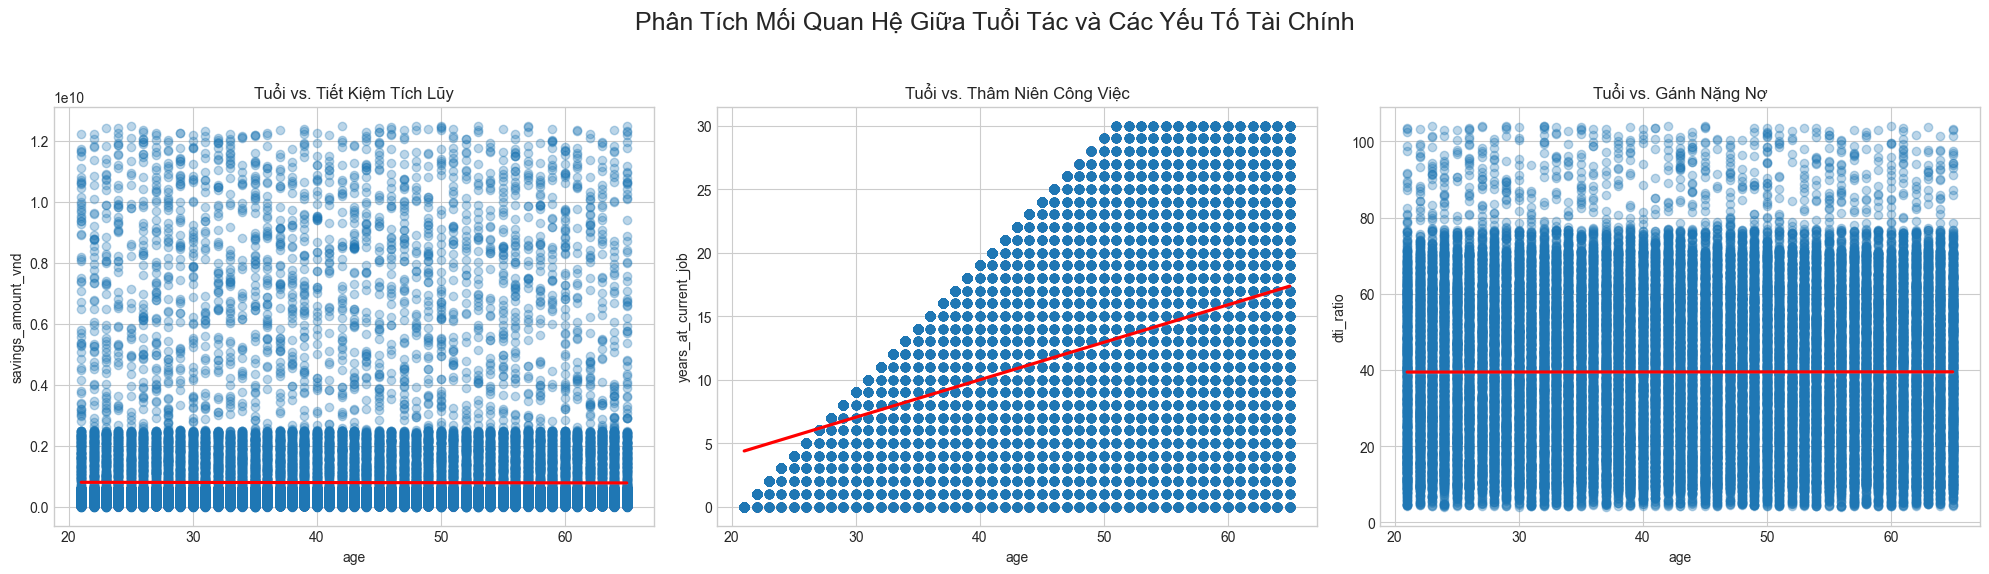

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Giả sử df_cluster là DataFrame chứa các biến GỐC (chưa scale) và cột 'segment'

# Lấy một mẫu nhỏ hơn để vẽ cho nhanh và đỡ rối
#df_sample = df_cluster.sample(n=5000, random_state=42)

# Tạo subplot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Phân Tích Mối Quan Hệ Giữa Tuổi Tác và Các Yếu Tố Tài Chính', fontsize=18)

# 1. Tuổi vs. Tiết kiệm
sns.regplot(data=df, x='age', y='savings_amount_vnd', ax=axes[0],
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[0].set_title('Tuổi vs. Tiết Kiệm Tích Lũy')

# 2. Tuổi vs. Thâm niên
sns.regplot(data=df, x='age', y='years_at_current_job', ax=axes[1],
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[1].set_title('Tuổi vs. Thâm Niên Công Việc')

# 3. Tuổi vs. Tỷ lệ Nợ/Thu nhập (DTI)
sns.regplot(data=df_encoded, x='age', y='dti_ratio', ax=axes[2],
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[2].set_title('Tuổi vs. Gánh Nặng Nợ')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

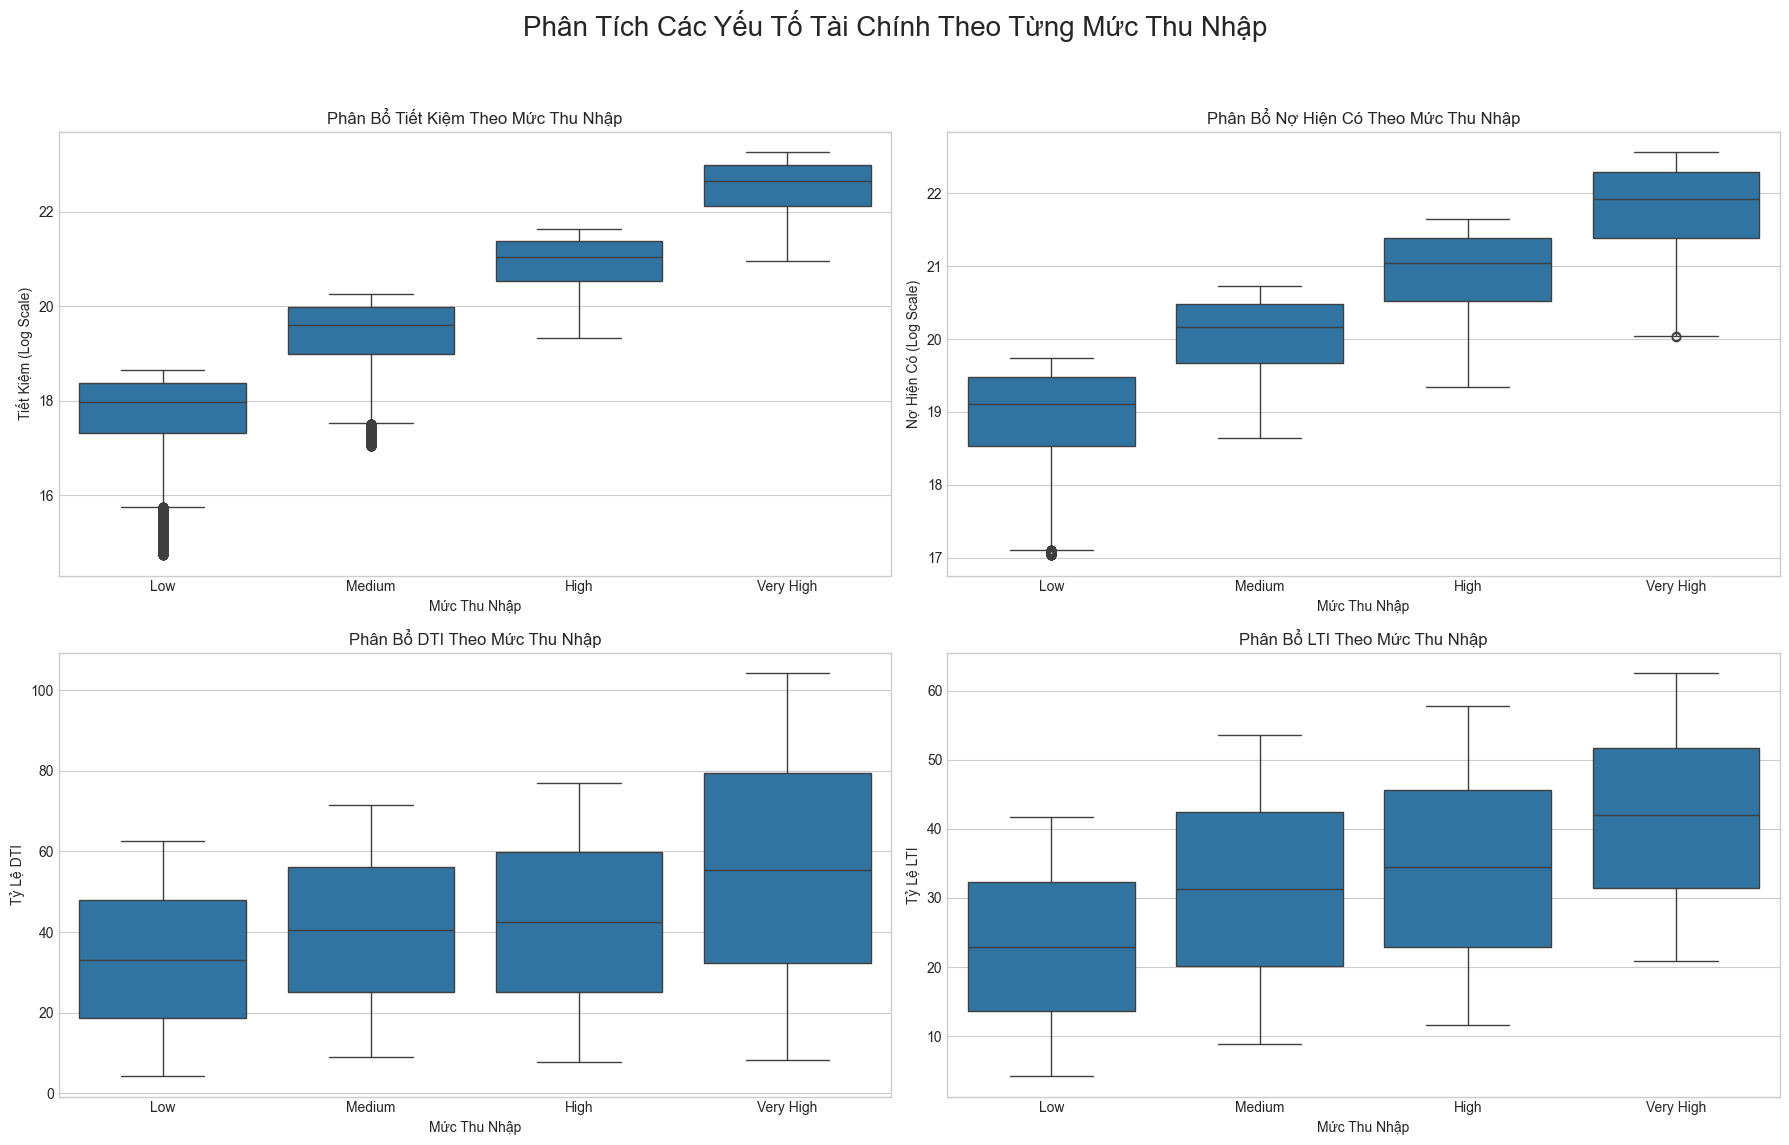

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Giả sử df_cluster là DataFrame chứa các biến GỐC và cột 'segment'
# và df_violin là bản sao đã được gán nhãn lại cho income_level_en

# (Nếu chưa có, hãy tạo lại df_violin)
df_violin = df_encoded.copy()
income_labels = {0: 'Low', 1: 'Medium', 2: 'High', 3: 'Very High'}
df_violin['income_level_label'] = df_violin['income_level_en'].map(income_labels)
order = ['Low', 'Medium', 'High', 'Very High']


# --- Tạo subplot ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Phân Tích Các Yếu Tố Tài Chính Theo Từng Mức Thu Nhập', fontsize=20)


# 1. Mức Thu Nhập vs. Tiết kiệm
sns.boxplot(data=df_violin, x='income_level_label', y='savings_amount_vnd_log', order=order, ax=axes[0, 0])
axes[0, 0].set_title('Phân Bổ Tiết Kiệm Theo Mức Thu Nhập')
axes[0, 0].set_xlabel('Mức Thu Nhập')
axes[0, 0].set_ylabel('Tiết Kiệm (Log Scale)')

# 2. Mức Thu Nhập vs. Nợ hiện có
sns.boxplot(data=df_violin, x='income_level_label', y='existing_debt_vnd_log', order=order, ax=axes[0, 1])
axes[0, 1].set_title('Phân Bổ Nợ Hiện Có Theo Mức Thu Nhập')
axes[0, 1].set_xlabel('Mức Thu Nhập')
axes[0, 1].set_ylabel('Nợ Hiện Có (Log Scale)')

# 3. Mức Thu Nhập vs. Tỷ lệ Nợ/Thu nhập (DTI)
sns.boxplot(data=df_violin, x='income_level_label', y='dti_ratio', order=order, ax=axes[1, 0])
axes[1, 0].set_title('Phân Bổ DTI Theo Mức Thu Nhập')
axes[1, 0].set_xlabel('Mức Thu Nhập')
axes[1, 0].set_ylabel('Tỷ Lệ DTI')

# 4. Mức Thu Nhập vs. Tỷ lệ Vay/Thu nhập (LTI)
sns.boxplot(data=df_violin, x='income_level_label', y='lti_ratio', order=order, ax=axes[1, 1])
axes[1, 1].set_title('Phân Bổ LTI Theo Mức Thu Nhập')
axes[1, 1].set_xlabel('Mức Thu Nhập')
axes[1, 1].set_ylabel('Tỷ Lệ LTI')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

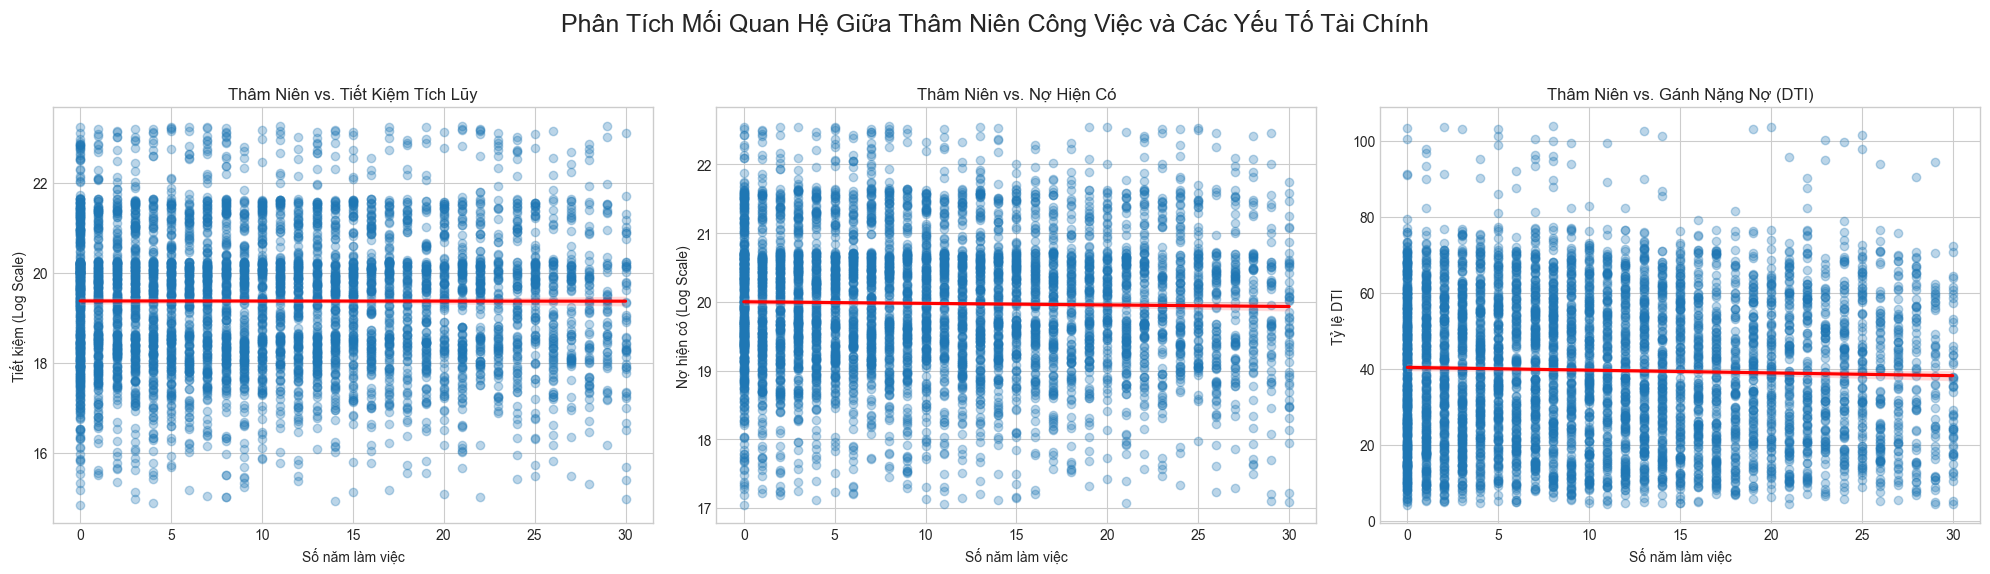

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Giả sử df_cluster là DataFrame chứa các biến GỐC (chưa scale)
# Lấy một mẫu nhỏ hơn để vẽ cho nhanh và đỡ rối
df_sample = df_encoded.sample(n=5000, random_state=42)

# Tạo subplot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Phân Tích Mối Quan Hệ Giữa Thâm Niên Công Việc và Các Yếu Tố Tài Chính', fontsize=18)

# 1. Thâm niên vs. Tiết kiệm
sns.regplot(data=df_sample, x='years_at_current_job', y='savings_amount_vnd_log', ax=axes[0],
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[0].set_title('Thâm Niên vs. Tiết Kiệm Tích Lũy')
axes[0].set_xlabel('Số năm làm việc')
axes[0].set_ylabel('Tiết kiệm (Log Scale)')

# 2. Thâm niên vs. Nợ hiện có
sns.regplot(data=df_sample, x='years_at_current_job', y='existing_debt_vnd_log', ax=axes[1],
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[1].set_title('Thâm Niên vs. Nợ Hiện Có')
axes[1].set_xlabel('Số năm làm việc')
axes[1].set_ylabel('Nợ hiện có (Log Scale)')


# 3. Thâm niên vs. Tỷ lệ Nợ/Thu nhập (DTI)
sns.regplot(data=df_sample, x='years_at_current_job', y='dti_ratio', ax=axes[2],
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[2].set_title('Thâm Niên vs. Gánh Nặng Nợ (DTI)')
axes[2].set_xlabel('Số năm làm việc')
axes[2].set_ylabel('Tỷ lệ DTI')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

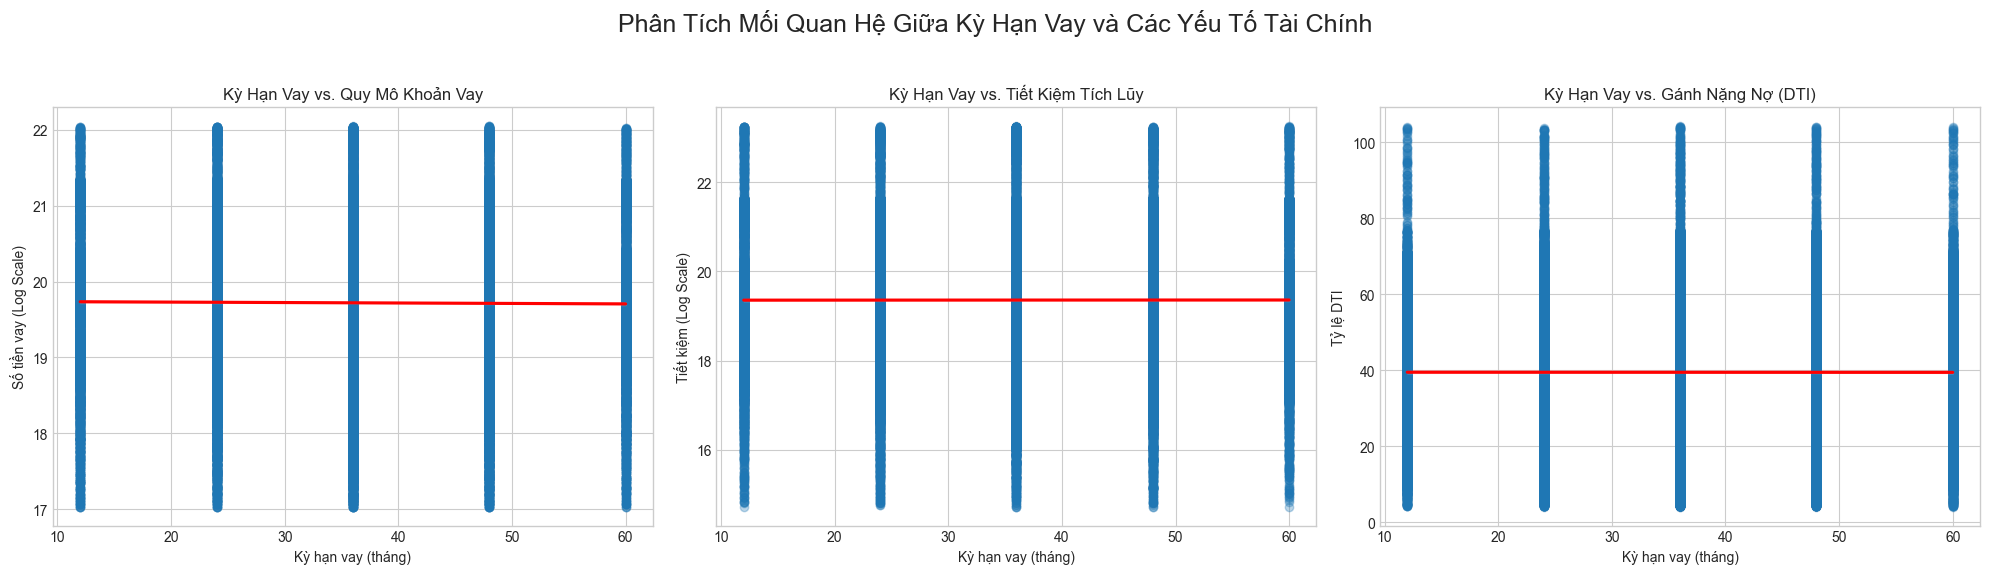

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Giả sử df_cluster là DataFrame chứa các biến GỐC (chưa scale)
# Lấy một mẫu nhỏ hơn để vẽ cho nhanh và đỡ rối
#df_sample = df_cluster.sample(n=5000, random_state=42)

# Tạo subplot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Phân Tích Mối Quan Hệ Giữa Kỳ Hạn Vay và Các Yếu Tố Tài Chính', fontsize=18)

# 1. Kỳ hạn vay vs. Số tiền vay
sns.regplot(data=df_encoded, x='loan_term_months', y='requested_loan_amount_vnd_log', ax=axes[0],
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[0].set_title('Kỳ Hạn Vay vs. Quy Mô Khoản Vay')
axes[0].set_xlabel('Kỳ hạn vay (tháng)')
axes[0].set_ylabel('Số tiền vay (Log Scale)')

# 2. Kỳ hạn vay vs. Tiết kiệm
sns.regplot(data=df_encoded, x='loan_term_months', y='savings_amount_vnd_log', ax=axes[1],
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[1].set_title('Kỳ Hạn Vay vs. Tiết Kiệm Tích Lũy')
axes[1].set_xlabel('Kỳ hạn vay (tháng)')
axes[1].set_ylabel('Tiết kiệm (Log Scale)')


# 3. Kỳ hạn vay vs. Tỷ lệ Nợ/Thu nhập (DTI)
sns.regplot(data=df_encoded, x='loan_term_months', y='dti_ratio', ax=axes[2],
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[2].set_title('Kỳ Hạn Vay vs. Gánh Nặng Nợ (DTI)')
axes[2].set_xlabel('Kỳ hạn vay (tháng)')
axes[2].set_ylabel('Tỷ lệ DTI')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

ValueError: Could not interpret value `loan_term_months` for `y`. An entry with this name does not appear in `data`.

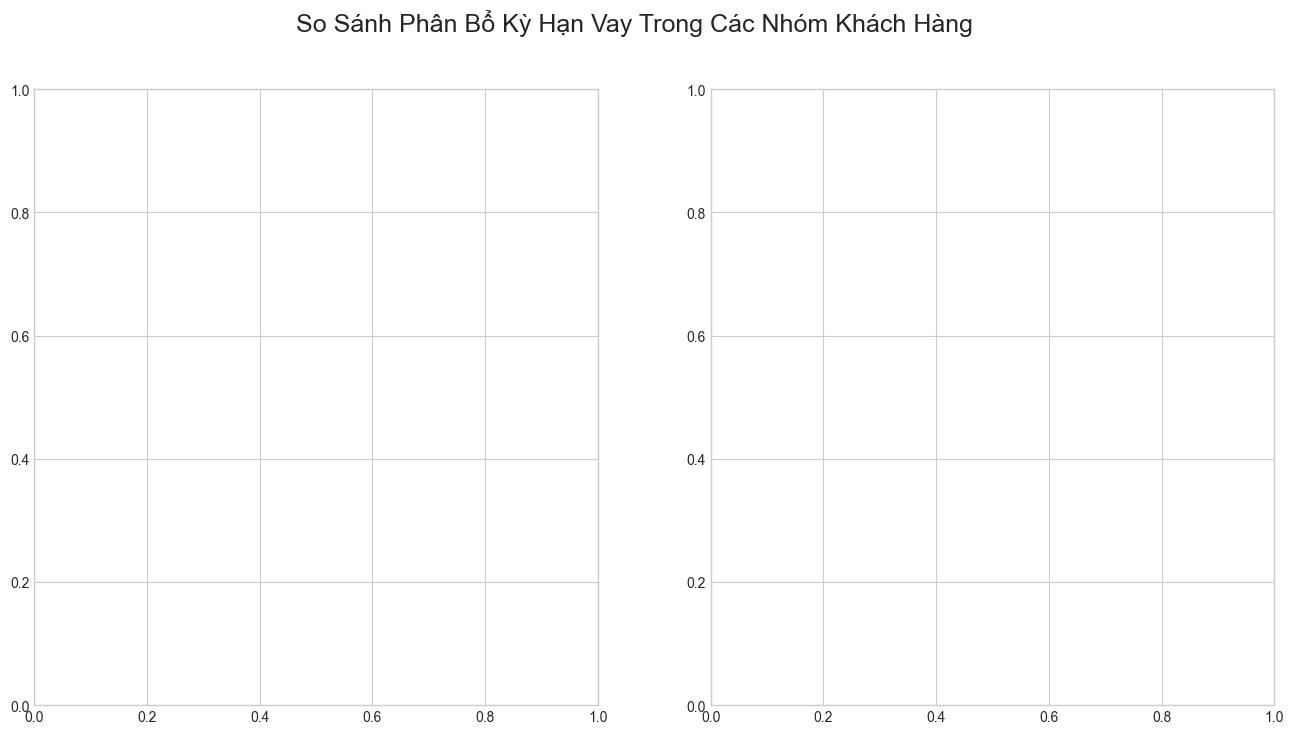

In [ ]:
# Sử dụng toàn bộ df_cluster để có phân bổ chính xác nhất
# Tạo lại DataFrame tạm thời df_violin nếu cần
df_violin = df_cluster.copy()
income_labels = {0: 'Low', 1: 'Medium', 2: 'High', 3: 'Very High'}
df_violin['income_level_label'] = df_violin['income_level_en'].map(income_labels)
order = ['Low', 'Medium', 'High', 'Very High']


fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('So Sánh Phân Bổ Kỳ Hạn Vay Trong Các Nhóm Khách Hàng', fontsize=18)

# 1. Kỳ hạn vay theo Mức Thu Nhập
sns.boxplot(data=df_violin, x='income_level_label', y='loan_term_months', order=order, ax=axes[0])
axes[0].set_title('Phân Bổ Kỳ Hạn Vay Theo Mức Thu Nhập')
axes[0].set_xlabel('Mức Thu Nhập')
axes[0].set_ylabel('Kỳ hạn vay (tháng)')


# 2. Kỳ hạn vay theo Mục đích vay
# Lấy lại cột gốc từ df
df_violin['loan_purpose'] = df['loan_purpose']
# Tăng kích thước phông chữ cho trục x nếu tên mục đích dài
axes[1].tick_params(axis='x', rotation=45)
sns.boxplot(data=df_violin, x='loan_purpose', y='loan_term_months', ax=axes[1])
axes[1].set_title('Phân Bổ Kỳ Hạn Vay Theo Mục Đích Vay')
axes[1].set_xlabel('Mục Đích Vay')
axes[1].set_ylabel('Kỳ hạn vay (tháng)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
df_encoded['loan_term_months'].value_counts()

loan_term_months
36    17591
48    12557
24     9804
60     5036
12     5012
Name: count, dtype: int64